<a href="https://colab.research.google.com/github/Batman511/AI-Samsung-NLP/blob/main/%D0%9A%D1%83%D1%80%D1%81_AI_Samsung_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Выполнение заданий курса

Разбиение предложения на токены с помощью регулярных выражений

https://habr.com/ru/post/349860/

In [ ]:
import re
# r'\w' - делит на буквы
# r'\w+' - делит на слова без знаков препинания
# r'\S+' - тоже на слова со знаками
# r' ' - все пробелы
# r'\w+|\S' - делит на слова и знаки препинания, почту тоже делит
# r'((?:\w+@\w+\.\w+)|\w+|\S)' - делит на слова и знаки препинания, но почту оставляет


txt = "Пожалуйста, отправляйте свои заявки на адрес электронной почты inbox@example.com или по телефону 123456."
tokenize_regex = re.compile(r'((?:\w+@\w+\.\w+)|\w+|\S)', re.I)
tokens = tokenize_regex.findall(txt)

print(tokens)

['Пожалуйста', ',', 'отправляйте', 'свои', 'заявки', 'на', 'адрес', 'электронной', 'почты', 'inbox@example.com', 'или', 'по', 'телефону', '123456', '.']


Словарь и частоты

In [ ]:
text = "казнить нельзя, помиловать. нельзя наказывать. казнить, нельзя помиловать. нельзя освободить. нельзя не помиловать. обязательно освободить."

#словарь для слов 
words = {} 


# Разбить текст на слова 
for word in text.split(): 
    words[word] = words.get(word, 0) + 1 

print(words) 
weights = [] 



for word in words.keys(): 
    weights.append(words[word])

list2 = weights
list1 = words
zipped_lists = zip(list1, list2)

sorted_list1 = sorted(zipped_lists)
weights_2 = [list2/4 for list1, list2 in sorted_list1]

print(sorted_list1) 

{'казнить': 1, 'нельзя,': 1, 'помиловать.': 3, 'нельзя': 4, 'наказывать.': 1, 'казнить,': 1, 'освободить.': 2, 'не': 1, 'обязательно': 1}
[('казнить', 1), ('казнить,', 1), ('наказывать.', 1), ('не', 1), ('нельзя', 4), ('нельзя,', 1), ('обязательно', 1), ('освободить.', 2), ('помиловать.', 3)]


Сортировка связных списков

In [ ]:
list1 = ['banana', 'apple', 'orange']
list2 = ['dog', 'cat', 'fish']

zipped_lists = zip(list1, list2)
sorted_list1 = sorted(zipped_lists)
list2_new = [list2 for list1, list2 in sorted_list1]

print("Sorted list1:", sorted_list1)
print("New list2:", list2_new)

Sorted list1: [('apple', 'cat'), ('banana', 'dog'), ('orange', 'fish')]
New list2: ['cat', 'dog', 'fish']


# Тематическая классификация новостных текстов с PyTorch - TFIDF и LogReg

Имеем 20 тематик и сообщения с почты

In [ ]:
# библиотека с примитивами для прохождения курса
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

In [ ]:
import dlnlputils
print(dlnlputils.__file__)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import collections

import torch
from torch import nn
from torch.nn import functional as F

# библиотеки курса
import dlnlputils
from dlnlputils.data import tokenize_text_simple_regex, tokenize_corpus, build_vocabulary, \
    vectorize_texts, SparseFeaturesDataset
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Предобработка текстов и подготовка признаков

In [ ]:
train_source = fetch_20newsgroups(subset='train')
test_source = fetch_20newsgroups(subset='test')

print('Количество обучающих текстов', len(train_source['data']))
print('Количество тестовых текстов', len(test_source['data']))
print()
print(train_source['data'][0].strip())

print()
print('Класс', train_source['target'][0])

Количество обучающих текстов 11314
Количество тестовых текстов 7532

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

Класс 7


### Подготовка признаков

Токенизация - обязательный пункт

In [ ]:
train_tokenized = tokenize_corpus(train_source['data'])
test_tokenized = tokenize_corpus(test_source['data'])

print(' '.join(train_tokenized[0]))
# остаются только последовательности букв и цифр

from lerxst where thing subject what this nntp posting host rac3 organization university maryland college park lines wondering anyone there could enlighten this other door sports looked from late early called bricklin doors were really small addition front bumper separate from rest body this know anyone tellme model name engine specs years production where this made history whatever info have this funky looking please mail thanks brought your neighborhood lerxst


Подготовка словаря

In [ ]:
# слишком частые токены (80% текстов) не нужны 
MAX_DF = 0.8
# токены встречающиеся меньше 5 раз не нужны
MIN_COUNT = 5
# строим словарь с помощью доп библиотеки
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=MAX_DF, min_count=MIN_COUNT)
UNIQUE_WORDS_N = len(vocabulary)
print('Количество уникальных токенов', UNIQUE_WORDS_N)
print('10 самый популярных',list(vocabulary.items())[:10])

Количество уникальных токенов 21628
10 самый популярных [('that', 0), ('this', 1), ('have', 2), ('with', 3), ('writes', 4), ('article', 5), ('posting', 6), ('host', 7), ('nntp', 8), ('there', 9)]


проверяем закон Ципфа

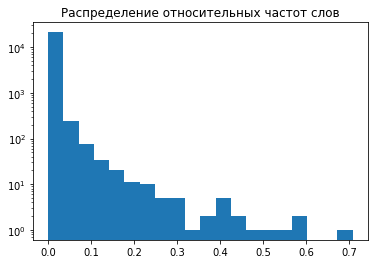

In [ ]:
plt.hist(word_doc_freq, bins=20)
plt.title('Распределение относительных частот слов')
plt.yscale('log');

Строим матрицу признаков по методу мешка слов

In [ ]:
VECTORIZATION_MODE = 'tfidf'
train_vectors = vectorize_texts(train_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)
test_vectors = vectorize_texts(test_tokenized, vocabulary, word_doc_freq, mode=VECTORIZATION_MODE)

print('Размерность матрицы признаков обучающей выборки', train_vectors.shape)
print('Размерность матрицы признаков тестовой выборки', test_vectors.shape)
print()
print('Количество ненулевых элементов в обучающей выборке', train_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(train_vectors.nnz * 100 / (train_vectors.shape[0] * train_vectors.shape[1])))
print()
print('Количество ненулевых элементов в тестовой выборке', test_vectors.nnz)
print('Процент заполненности матрицы признаков {:.2f}%'.format(test_vectors.nnz * 100 / (test_vectors.shape[0] * test_vectors.shape[1])))
# строки это примеры, а столбцы - токены

Размерность матрицы признаков обучающей выборки (11314, 21628)
Размерность матрицы признаков тестовой выборки (7532, 21628)

Количество ненулевых элементов в обучающей выборке 1126792
Процент заполненности матрицы признаков 0.46%

Количество ненулевых элементов в тестовой выборке 721529
Процент заполненности матрицы признаков 0.44%


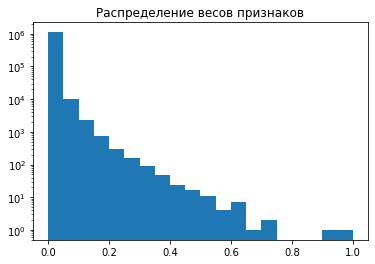

In [ ]:
plt.hist(train_vectors.data, bins=20)
plt.title('Распределение весов признаков')
plt.yscale('log');

### Распределение классов

In [ ]:
UNIQUE_LABELS_N = len(set(train_source['target']))
print('Количество уникальных меток', UNIQUE_LABELS_N)

Количество уникальных меток 20


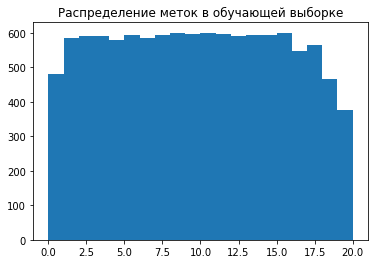

In [ ]:
plt.hist(train_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в обучающей выборке');

Видно, что распределены равномерно

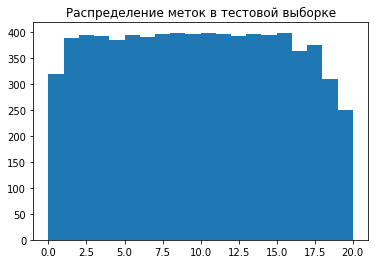

In [ ]:
plt.hist(test_source['target'], bins=np.arange(0, 21))
plt.title('Распределение меток в тестовой выборке');

### PyTorch Dataset

Обернем данные в датасет для удобства

In [ ]:
train_dataset = SparseFeaturesDataset(train_vectors, train_source['target'])
test_dataset = SparseFeaturesDataset(test_vectors, test_source['target'])

## Обучение модели на PyTorch

In [ ]:
# входы - токены, выходы - классы
model = nn.Linear(UNIQUE_WORDS_N, UNIQUE_LABELS_N)  # с помощью сигмоиды в конце сделаем ее логистической регрессией

# меняем градиентный шаг если 5 эпох loss на валид выборке не меняется
scheduler = lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

best_val_loss, best_model = train_eval_loop(model=model,
                                            train_dataset=train_dataset,
                                            val_dataset=test_dataset,
                                            criterion=F.cross_entropy,
                                            lr=1e-1,
                                            epoch_n=200,
                                            batch_size=32,
                                            l2_reg_alpha=0,
                                            lr_scheduler_ctor=scheduler)

Эпоха 0
Эпоха: 354 итераций, 4.25 сек
Среднее значение функции потерь на обучении 2.2252535607855197
Среднее значение функции потерь на валидации 2.113704176272376
Новая лучшая модель!

Эпоха 1
Эпоха: 354 итераций, 4.02 сек
Среднее значение функции потерь на обучении 0.9165900048226286
Среднее значение функции потерь на валидации 1.6821974248199139
Новая лучшая модель!

Эпоха 2
Эпоха: 354 итераций, 3.42 сек
Среднее значение функции потерь на обучении 0.46601731696371307
Среднее значение функции потерь на валидации 1.4643919902332758
Новая лучшая модель!

Эпоха 3
Эпоха: 354 итераций, 3.55 сек
Среднее значение функции потерь на обучении 0.28363620860260086
Среднее значение функции потерь на валидации 1.3450396257942006
Новая лучшая модель!

Эпоха 4
Эпоха: 354 итераций, 3.43 сек
Среднее значение функции потерь на обучении 0.19072445673541835
Среднее значение функции потерь на валидации 1.2602427210343086
Новая лучшая модель!

Эпоха 5
Эпоха: 354 итераций, 3.38 сек
Среднее значение функции 

## Оценка качества

In [ ]:
train_pred = predict_with_model(best_model, train_dataset)

train_loss = F.cross_entropy(torch.from_numpy(train_pred),
                             torch.from_numpy(train_source['target']).long())

print('Среднее значение функции потерь на обучении', float(train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], train_pred.argmax(-1)))
print()



test_pred = predict_with_model(best_model, test_dataset)

test_loss = F.cross_entropy(torch.from_numpy(test_pred),
                            torch.from_numpy(test_source['target']).long())

print('\nСреднее значение функции потерь на валидации', float(test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], test_pred.argmax(-1)))

100%|██████████| 354/353.5625 [00:02<00:00, 135.48it/s]


Среднее значение функции потерь на обучении 0.002232220256701112
Доля верных ответов 0.9994696835778681



236it [00:01, 156.67it/s]                             

Среднее значение функции потерь на валидации 0.9289422035217285
Доля верных ответов 0.76805629314923


## Альтернативная реализация на scikit-learn

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# задаем алгоритм векторизации текстов - TfidfVectorizer
sklearn_pipeline = Pipeline((('vect', TfidfVectorizer(tokenizer=tokenize_text_simple_regex,
                                                      max_df=MAX_DF,
                                                      min_df=MIN_COUNT)),
                             ('cls', LogisticRegression())))
# обучаем
sklearn_pipeline.fit(train_source['data'], train_source['target']);

## Оценка качества

In [ ]:
sklearn_train_pred = sklearn_pipeline.predict_proba(train_source['data'])
sklearn_train_loss = F.cross_entropy(torch.from_numpy(sklearn_train_pred),
                                                 torch.from_numpy(train_source['target']))
print('Среднее значение функции потерь на обучении', float(sklearn_train_loss))
print('Доля верных ответов', accuracy_score(train_source['target'], sklearn_train_pred.argmax(-1)))
print()

sklearn_test_pred = sklearn_pipeline.predict_proba(test_source['data'])
sklearn_test_loss = F.cross_entropy(torch.from_numpy(sklearn_test_pred),
                                                torch.from_numpy(test_source['target']))
print('Среднее значение функции потерь на валидации', float(sklearn_test_loss))
print('Доля верных ответов', accuracy_score(test_source['target'], sklearn_test_pred.argmax(-1)))

# Обучение Word2Vec с помощью Gensim

https://github.com/sic-rus-ai/stepik-dl-nlp/blob/master/task2_word_embeddings.ipynb

In [ ]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

In [ ]:
import gensim

import pandas as pd
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

import dlnlputils
from dlnlputils.data import tokenize_corpus
from dlnlputils.visualization import plot_vectors

Данные

In [ ]:
full_dataset = list(pd.read_csv('./stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1 tablespoon Dijon mustard
2 tablespoons chopped fresh cilantro
1 scallion, finely chopped
28 medium-size plum tomatoes, the core end cut off, halved lengthwise
1/2 green Thai chili pepper, stem removed
1 tablespoon extra virgin olive oil
3 cups sugar
1 cup grated mozzarella cheese
Powdered sugar for garnish
2 tablespoons chopped mint, optional


In [ ]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)

word2vec = gensim.models.Word2Vec(sentences=train_tokenized,
                                  window=5, min_count=5, workers=4,
                                  sg=1)

In [ ]:
# слова, похожие на слово "курица"
word2vec.wv.most_similar('chicken')

[('duck', 0.8003277778625488),
 ('turkey', 0.747490644454956),
 ('thighs', 0.7004173398017883),
 ('quail', 0.685941755771637),
 ('carcass', 0.6851289868354797),
 ('veal', 0.684583306312561),
 ('simmering', 0.6833616495132446),
 ('defatted', 0.6804994344711304),
 ('rich', 0.6780915260314941),
 ('drumsticks', 0.6770983934402466)]

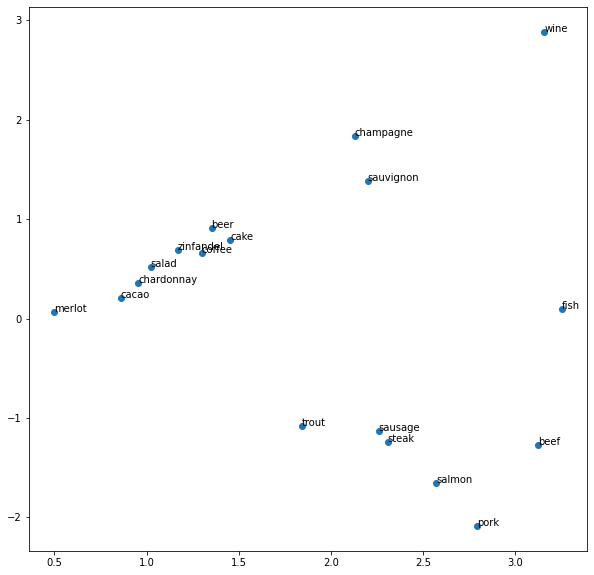

In [ ]:
# нарисуем вектора слов на плоскости
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']

gensim_words = [w for w in test_words ]  # if w in word2vec.wv.vocab
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

Можно выделить кластер напитков, например

## Загрузка предобученного Word2Vec (если нужно)

https://rusvectores.org/ru/ 

In [ ]:
import gensim.downloader as api

available_models = api.info()['models'].keys()
print('\n'.join(available_models))

pretrained = api.load('glove-twitter-25')  # могут много весить
# word2vec-google-news-300 по хорошему, но весит 1.5Gb

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis
[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
# список похожих слов
pretrained.most_similar('cheese')

[('salad', 0.9663354754447937),
 ('fries', 0.9657281041145325),
 ('chicken', 0.9655250906944275),
 ('peanut', 0.9608643054962158),
 ('butter', 0.9571344256401062),
 ('corn', 0.9545068740844727),
 ('bread', 0.9532765746116638),
 ('soup', 0.9529144763946533),
 ('cookies', 0.9505582451820374),
 ('pancakes', 0.9453889727592468)]

Решаем задачу аналогии

In [ ]:
# спросили у модели какие слова относятся к мужчине как королева относится к женщине
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

[('so', 0.9094545245170593),
 ('sad', 0.8963088393211365),
 ('i', 0.891746461391449),
 ('glad', 0.8785857558250427),
 ('mine', 0.8765345215797424),
 ('fine', 0.8713780045509338),
 ('ever', 0.8683590888977051),
 ('cos', 0.8655498027801514),
 ('forever', 0.8621163368225098),
 ('look', 0.8611385822296143)]

Визуализируем похожие слова и их расположение

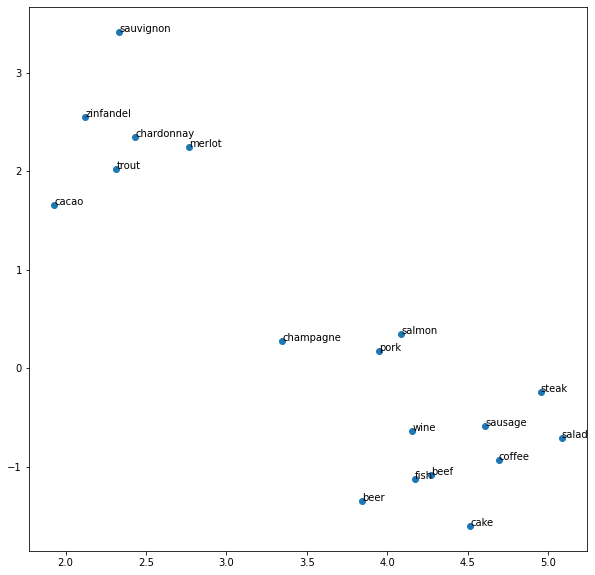

In [ ]:
pretrained_words = [w for w in test_words]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

# Сверточная нейросеть

https://github.com/sic-rus-ai/stepik-dl-nlp/blob/master/task3_cnn_postag.ipynb

# Рекурентная нейросеть PyTorch

https://github.com/sic-rus-ai/stepik-dl-nlp/blob/master/task4_RNN_name_generator.ipynb   генерация лозунгов

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys(): 
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn,length=len(uploaded[fn])))

Saving author_quotes.txt to author_quotes.txt
User uploaded file "author_quotes.txt" with length 4757084 bytes


In [ ]:
!ls

author_quotes.txt  sample_data


Подготавливаем данные

In [ ]:
with open('author_quotes.txt') as input_file:
    quotes = input_file.read()[:-1].split('\n')
    quotes = [' ' + line for line in quotes]

# Препроцессинг
tokens = list(set(''.join(quotes)))

# Символы -> id
token_to_id = {token: idx for idx, token in enumerate(tokens)}
num_tokens = len(tokens) 

# Проверяем, что все хорошо
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"
print("Seems alright!")   

Seems alright!


In [ ]:
# Необходимые функции
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix


MAX_LENGTH = max(map(len, quotes))
# RNN: генерация лозунгов
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = 64
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

Используем готовые модули для создания модели и ее обучения

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from IPython.display import clear_output
from random import sample

class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x, Variable) and isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp  
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

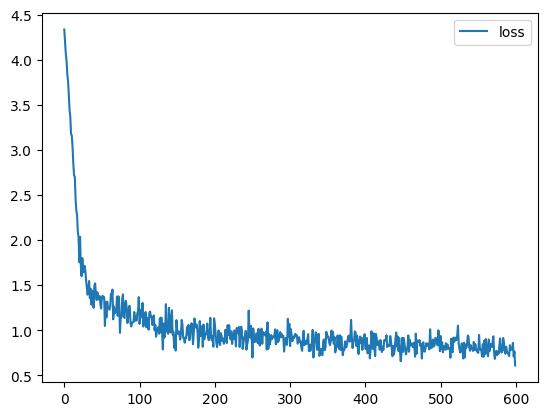

In [ ]:
MAX_LENGTH = max(map(len, quotes))

batch_ix = to_matrix(sample(quotes, 32), token_to_id, max_len=MAX_LENGTH)
batch_ix = Variable(torch.LongTensor(batch_ix))
logp_seq = model(batch_ix)

loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))
loss.backward()



# Обучение в реальном времени
MAX_LENGTH = max(map(len, quotes))

for i in range(200):
    batch_ix = to_matrix(sample(quotes, 32), token_to_id, max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:25]) > np.mean(history[-25:]), "RNN didn't converge."

In [ ]:
history[-1]

array(0.60824156, dtype=float32)

Генерация

In [ ]:
for _ in range(10):
    print(generate_sample(model))

# Трансформер для генерации текста

https://github.com/sic-rus-ai/stepik-dl-nlp/blob/master/task5_text_transformer.ipynb

In [ ]:
!pip dlnlputils
import dlnlputils
from dlnlputils.data import LanguageModelDataset, GreedyGenerator

In [ ]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen  x BatchSize x EmbSize
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

In [ ]:
torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   256,
                                   BatchFirstTransformerEncoder(
                                       nn.TransformerEncoderLayer(
                                           d_model=256,
                                           nhead=16,
                                           dim_feedforward=512,
                                           dropout=0.1),
                                       num_layers=3),
                                   emb_dropout=0.1)
print('Количество параметров', get_params_number(torch_transf_model))

In [ ]:
(best_val_loss,
 best_torch_transf_model) = train_eval_loop(torch_transf_model,
                                            train_dataset,
                                            test_dataset,
                                            lm_cross_entropy,
                                            lr=2e-3,
                                            epoch_n=2000,
                                            batch_size=512,
                                            device='cuda',
                                            early_stopping_patience=50,
                                            max_batches_per_epoch_train=1000,
                                            max_batches_per_epoch_val=1000,
                                            lr_scheduler_ctor=lr_scheduler)

In [ ]:
# сохранение лучшей модели
torch.save(best_torch_transf_model.state_dict(), './models/war_and_peace_torch_transf_best.pth')
# загрузка лучшей модели
torch_transf_model.load_state_dict(torch.load('./models/war_and_peace_torch_transf_best.pth'))

# LSTM сеть для определения сущностей в рецептах

https://github.com/sic-rus-ai/stepik-dl-nlp/blob/master/task6_recipe_ner.ipynb

In [ ]:
EMBEDDING_DIM = 32
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)


class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
loss_function = nn.NLLLoss() 
optimizer     = optim.SGD(model.parameters(), lr=0.1)        

In [ ]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(1): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре 
        encoded_tags   = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов
        
        tag_scores     = model(encoded_recipe)

        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()
        
        
        if i % 500 == 0:
            liveplot.update({'negative log likelihood loss': loss})
            liveplot.draw()
            
            
        if i == 15000:
            break

In [ ]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре
    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)
    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    return decoded_tags

for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,7000)]
    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    show_markup(recipe, tags)

    print('предсказанные тэги:')
    show_markup(recipe, tags_pred)
    print()

# ENC+DEC для Генерации кода по вопросам со StackOverflow

https://github.com/sic-rus-ai/stepik-dl-nlp/blob/master/task8_generate_stackoverflow_code.ipynb

# Ссылки на исходники мощных моделей

Transformer-XL https://github.com/kimiyoung/transformer-xl/

BERT https://github.com/google-research/bert

ELMO https://github.com/allenai/bilm-tf

GPT-2 https://github.com/openai/gpt-2

OpenAI Transformer https://github.com/openai/finetune-transformer-lm

# Определение эмоциональной окраски твитов с помощью BERT

https://github.com/sic-rus-ai/stepik-dl-nlp/blob/master/task9_bert_sentiment_analysis.ipynb 

# Генерация названий научных статей c помощью трансформера

In [ ]:
pip install -U transformers

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys(): 
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn,length=len(uploaded[fn])))

In [ ]:
import numpy as np 
import pandas as pd  

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import spacy

import random
import math
import time
import os
import io

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
from sklearn.metrics import accuracy_score

import random
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
number_lines = 33_500
train = pd.read_csv('train.csv', encoding='utf8', nrows=number_lines)

for i in tqdm(range(len(train))):
    train['abstract'][i] = train['abstract'][i][:512]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



train_df, val_df = train_test_split(train, test_size=0.1)

100%|██████████| 33500/33500 [00:18<00:00, 1807.05it/s]


In [ ]:
from PIL import Image
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, df, tokenizer, transform=None):
        self.df = df
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_length = 512

        self.abstracts = self.tokenizer(list(df.abstract),
                                         padding='max_length',
                                         max_length=self.max_length,
                                         add_special_tokens = True).input_ids
        self.titles = self.tokenizer(list(df.title),
                                      padding='max_length',
                                      max_length=self.max_length,
                                      add_special_tokens = True).input_ids


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        abstract = self.abstracts[idx]
        title = self.titles[idx]

        encoding = {"input_ids": torch.tensor(abstract), "labels": torch.tensor(title)}
        return encoding

Скачивание предобученных моделей

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoTokenizer
from transformers import DataCollatorForSeq2Seq


name_pretrain_model = "google/pegasus-xsum"
tokenizer = AutoTokenizer.from_pretrained(name_pretrain_model)
model = AutoModelForSeq2SeqLM.from_pretrained(name_pretrain_model).to(device)

model.resize_token_embeddings(len(tokenizer))

train_dataset = TextDataset(train_df, tokenizer=tokenizer)
val_dataset = TextDataset(val_df, tokenizer=tokenizer)

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Обучение

Ошибка, связанная с версией библиотеки(

In [ ]:
!pip install torch==1.8.

In [ ]:
batch_size = 1
os.environ["WANDB_DISABLED"] = "true"
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

args = Seq2SeqTrainingArguments(
    output_dir="./",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_steps=100000000,
    save_total_limit=1,
    num_train_epochs=2,
    fp16=True,
    predict_with_generate=True
)

trainer = Seq2SeqTrainer(
    data_collator=seq2seq_data_collator,
    model=model,
    tokenizer=tokenizer,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    # data_collator=seq2seq_data_collator
)


trainer.train()

Вывод

In [ ]:
def get_title(text):
    x = tokenizer(text, return_tensors="pt").input_ids.to(device)
    generated_ids = model.generate(x)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text


submission_data = pd.read_csv('test (4).csv')
abstracts = submission_data['abstract'].values 



from IPython.display import clear_output 

titles = []
len_abstracts = len(abstracts)
for idx, abstract in enumerate(abstracts):
    title = get_title(abstract)
    titles.append(title)
    clear_output()
    print(f'ready {round(100 * idx / len_abstracts)}%')



import pickle
import string
from nltk.util import ngrams

submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('predicted_titles.csv')


def generate_csv(input_file='/kaggle/working/predicted_titles.csv',
                 output_file='submission.csv',
                 voc_file='/kaggle/input/title-generation/vocs.pkl'):
    '''
    Generates file in format required for submitting result to Kaggle

    Parameters:
        input_file (str) : path to csv file with your predicted titles.
                           Should have two fields: abstract and title
        output_file (str) : path to output submission file
        voc_file (str) : path to voc.pkl file
    '''
    data = pd.read_csv(input_file)
    with open(voc_file, 'rb') as voc_file:
        vocs = pickle.load(voc_file)

    with open(output_file, 'w') as res_file:
        res_file.write('Id,Predict\n')

    output_idx = 0
    for row_idx, row in data.iterrows():
        trg = row['title']
        if isinstance(trg, float):
            trg = 'nope'
            VOCAB_stoi = vocs[row_idx]
            trg_intersection = set(VOCAB_stoi.keys()).intersection(set(trg))
            trg_vec = np.zeros(len(VOCAB_stoi))
            
            for word in trg_intersection:
                trg_vec[VOCAB_stoi[word]] = 1
            
            with open(output_file, 'a') as res_file:
                for is_word in trg_vec:
                    res_file.write('{0},{1}\n'.format(output_idx, int(is_word)))
                    output_idx += 1
            
            continue 
        trg = trg.translate(str.maketrans('', '', string.punctuation)).lower().split()
        trg.extend(['_'.join(ngram) for ngram in list(ngrams(trg, 2)) + list(ngrams(trg, 3))])

        VOCAB_stoi = vocs[row_idx]
        trg_intersection = set(VOCAB_stoi.keys()).intersection(set(trg))
        trg_vec = np.zeros(len(VOCAB_stoi))

        for word in trg_intersection:
            trg_vec[VOCAB_stoi[word]] = 1

        with open(output_file, 'a') as res_file:
            for is_word in trg_vec:
                res_file.write('{0},{1}\n'.format(output_idx, int(is_word)))
                output_idx += 1


generate_csv()    

In [ ]:
submission = pd.read_csv('/kaggle/working/submission.csv', encoding='utf8')
submission